In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import rocketpy

from rocketpy import Environment, Flight, Function, Rocket, SolidMotor

plt.style.use("seaborn-v0_8-dark-palette")

In [25]:
parameters = {
    # Mass Details
    "rocket_mass": (18.998, 0.010),  # Rocket dry mass: 20.846 kg
    # propulsion details
    "motor_structure_mass": (1.848, 0.1),
    "burn_time": (3.433, 0.1),
    "nozzle_radius": (0.02475, 0.001),
    "throat_radius": (0.01075, 0.001),
    "grain_separation": (0.003, 0.001),
    "grain_density": (1519.708, 30),
    "grain_outer_radius": (0.033, 0.001),
    "grain_initial_inner_radius": (0.015, 0.002),
    "grain_initial_height": (0.12, 0.001),
    "grains_center_of_mass_position": (-0.35, 0.100),
    "nozzle_position": (0, 0.100),
    "motor_position": (3.391, 0.100),
    # aerodynamic details
    "center_of_mass_without_motor": (1.3, 0.100),
    "drag_coefficient": (0.44, 0.1),
    "inertia_i": (73.316, 0.3 * 73.316),
    "inertia_z": (0.15982, 0.3 * 0.15982),
    "radius": (0.1015, 0.001),
    "power_off_drag": (1, 0.033),
    "power_on_drag": (1, 0.033),
    ## nose cone
    "nose_length": (0.610, 0.001),
    "nose_radius": (0.1015, 0.001),
    "nose_position": (0, 0.100),
    ## fins
    "fin_span": (0.165, 0.001),
    "fin_root_chord": (0.152, 0.001),
    "fin_tip_chord": (0.0762, 0.001),
    "fin_sweep_angle": (13, 0.5),
    "fin_position": (3.050, 0.100),
    ## transitions
    "transition_top_radius": (0.1015, 0.010),
    "transition_bottom_radius": (0.0775, 0.010),
    "transition_length": (0.127, 0.010),
    "transition_position": (1.2, 0.010),
    # launch and environment details
    "wind_direction": (0, 3),
    "wind_speed": (1, 0.30),
    "inclination": (90, 1),
    "heading": (181, 3),
    "rail_length": (3.353, 0.001),
    # parachute details
    "cd_s_drogue": (1.5 * np.pi * (24 * 25.4 / 1000) * (24 * 25.4 / 1000) / 4, 0.1),
    "cd_s_main": (2.2 * np.pi * (120 * 25.4 / 1000) * (120 * 25.4 / 1000) / 4, 0.1),
    "lag_rec": (1, 0.5),
}

# rocket: nose_to_tail

In [26]:
# Environment conditions
import datetime

env = Environment(latitude=55.432968, longitude=-5.700802, elevation=5)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time


env.set_atmospheric_model(type="Forecast", file="GFS")

In [27]:
motor_l1395 = SolidMotor(
    thrust_source="motors/AeroTech_M1315W.eng",
    burn_time=parameters.get("burn_time")[0],
    dry_mass=parameters.get("motor_structure_mass")[0],
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=parameters.get("grains_center_of_mass_position")[0],
    grains_center_of_mass_position=parameters.get("grains_center_of_mass_position")[0],
    grain_number=5,
    grain_separation=parameters.get("grain_separation")[0],
    grain_density=parameters.get("grain_density")[0],
    grain_outer_radius=parameters.get("grain_outer_radius")[0],
    grain_initial_inner_radius=parameters.get("grain_initial_inner_radius")[0],
    grain_initial_height=parameters.get("grain_initial_height")[0],
    nozzle_radius=parameters.get("nozzle_radius")[0],
    throat_radius=parameters.get("throat_radius")[0],
    interpolation_method="linear",
    nozzle_position=parameters.get("nozzle_position")[0],
    coordinate_system_orientation="combustion_chamber_to_nozzle",  # combustion_chamber_to_nozzle"
)

In [28]:
ndrt2020 = Rocket(
    radius=parameters.get("radius")[0],
    mass=parameters.get("rocket_mass")[0],
    inertia=(
        parameters.get("inertia_i")[0],
        parameters.get("inertia_i")[0],
        parameters.get("inertia_z")[0],
    ),
    power_off_drag=parameters.get("drag_coefficient")[0],
    power_on_drag=parameters.get("drag_coefficient")[0],
    center_of_mass_without_motor=parameters.get("center_of_mass_without_motor")[0],
    coordinate_system_orientation="nose_to_tail",
)
ndrt2020.set_rail_buttons(1.5, 2, 45)

ndrt2020.add_motor(motor=motor_l1395, position=parameters.get("motor_position")[0])

In [29]:
nose_cone = ndrt2020.add_nose(
    length=parameters.get("nose_length")[0],
    kind="tangent",
    position=parameters.get("nose_position")[0],
)
fin_set = ndrt2020.add_trapezoidal_fins(
    4,
    span=parameters.get("fin_span")[0],
    root_chord=parameters.get("fin_root_chord")[0],
    tip_chord=parameters.get("fin_tip_chord")[0],
    position=parameters.get("fin_position")[0],
    sweep_angle=parameters.get("fin_sweep_angle")[0],
    radius=parameters.get("transition_bottom_radius")[0],
)
transition = ndrt2020.add_tail(
    top_radius=parameters.get("transition_top_radius")[0],
    bottom_radius=parameters.get("transition_bottom_radius")[0],
    length=parameters.get("transition_length")[0],
    position=parameters.get("transition_position")[0],
)

In [30]:
drogue = ndrt2020.add_parachute(
    "Drogue",
    cd_s=parameters.get("cd_s_drogue")[0],
    trigger="apogee",
    sampling_rate=105,
    lag=parameters.get("lag_rec")[0],
    noise=(0, 8.3, 0.5),
)
main = ndrt2020.add_parachute(
    "Main",
    cd_s=parameters.get("cd_s_main")[0],
    trigger=167.64,
    sampling_rate=105,
    lag=parameters.get("lag_rec")[0],
    noise=(0, 8.3, 0.5),
)

In [31]:
# Flight
flight = Flight(
    rocket=ndrt2020,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
    heading=parameters.get("heading")[0],
)

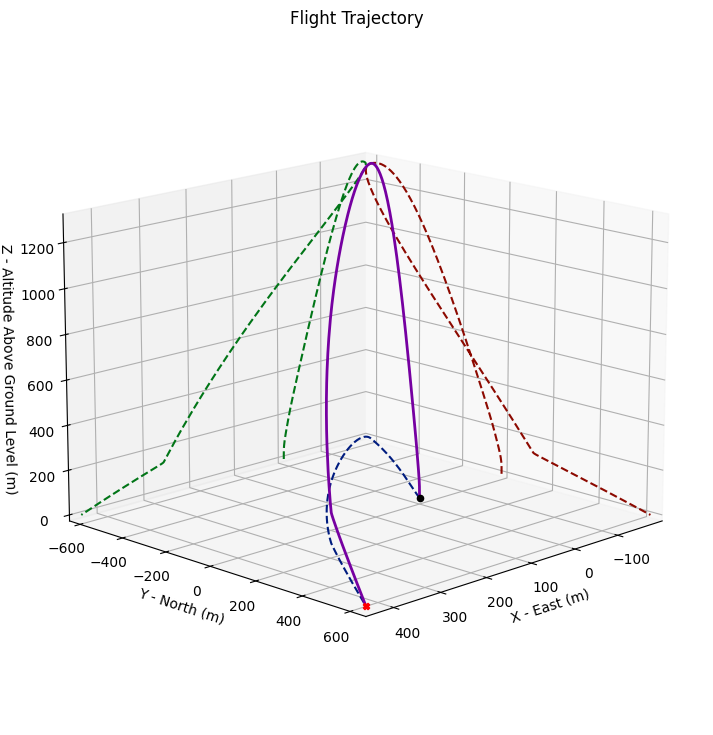

Function from R1 to R1 : (Time (s)) → (Vx (m/s))


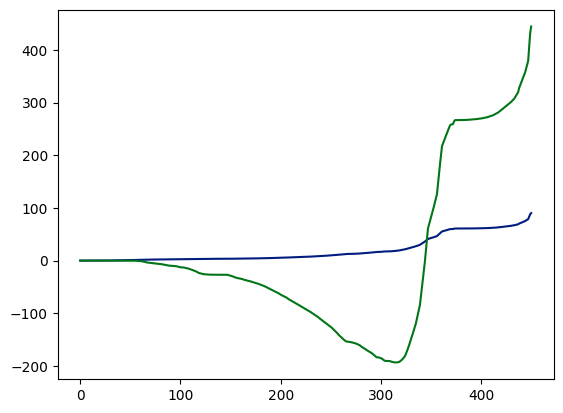

In [32]:
#Plotting

flight.plots.trajectory_3d()
print(flight.vx)

plt.plot(flight.x)

In [40]:
print(flight.x(1.5))

-0.973914352702411


In [44]:
#Function for exporting flight instances as CSV
import csv
import numpy as np

# Assuming `flight` is your Flight object instance and it now also includes:
# - Flight.ax(t), Flight.ay(t), Flight.az(t), Flight.alpha1(t), Flight.alpha2(t), and Flight.alpha3(t)

# Define the range of time and step size for which you want to export data
start_time = 0
end_time = 100  # Example: 100 seconds after launch
time_step = 0.001  # Example: Evaluate every second

# Define the CSV file name
csv_file_name = 'output.csv'

# Open a new CSV file for writing
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow([
        'Time', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ',
        'Euler 0', 'Euler 1', 'Euler 2', 'Euler 3',
        'Omega 1', 'Omega 2', 'Omega 3',
        'Latitude', 'Longitude', 'Inclination', 'Heading',
        'Ax', 'Ay', 'Az', 'Alpha 1', 'Alpha 2', 'Alpha 3'
    ])
    
    # Iterate over each time step and write data rows
    for t in np.arange(start_time, end_time + time_step, time_step):
        writer.writerow([
            t,
            flight.x(t),  # Assuming x is a function of time
            flight.y(t),  # Assuming y is a function of time
            flight.z(t),
            flight.vx(t),
            flight.vy(t),
            flight.vz(t),
            flight.e0(t),
            flight.e1(t),
            flight.e2(t),
            flight.e3(t),
            flight.w1(t),
            flight.w2(t),
            flight.w3(t),
            flight.latitude(t),
            flight.longitude(t),
            flight.inclination,  # Static value
            flight.heading,  # Static value
            flight.ax(t),  # Assuming ax is a function of time
            flight.ay(t),  # Assuming ay is a function of time
            flight.az(t),  # Assuming az is a function of time
            flight.alpha1(t),  # Assuming alpha1 is a function of time
            flight.alpha2(t),  # Assuming alpha2 is a function of time
            flight.alpha3(t)  # Assuming alpha3 is a function of time
        ])

print(f'Data exported to {csv_file_name}')
